# Criteria to select genes and cells

- eliminate proliferating cell types (not interested in proliferating cell states)
- remake the gene lists based on the DE new criteria (wilcox, pval threshold, sorted by logfc)

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#import milopy.core as milo
#import milopy.plot as milopl


In [2]:
sc.set_figure_params(dpi=50, dpi_save=600) # Makes it more visible

In [3]:
tmpfile = 'h5ad_files/Progenitors_lineage_wilcox_tmp.h5ad'

In [4]:
adata = sc.read_h5ad('../h5ad_files/PAN.A01.v01.raw_count.20210429.HSC_PROGENITORS.embedding.h5ad')
adata

AnnData object with n_obs × n_vars = 40422 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [5]:
adata.raw

In [6]:
adata

AnnData object with n_obs × n_vars = 40422 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [7]:
adata.obs["anno_lvl_2_final_clean"].cat.categories

Index(['CMP', 'CYCLING_MEMP', 'CYCLING_MPP', 'DN(P)_T', 'DN(early)_T',
       'DOUBLET_ERY_B', 'EARLY_MK', 'GMP', 'HSC_MPP', 'LMPP_MLP', 'MEMP',
       'MEP', 'PRE_PRO_B', 'PROMONOCYTE', 'PROMYELOCYTE', 'nan'],
      dtype='object')

In [8]:
progenitor = adata[adata.obs['anno_lvl_2_final_clean'].isin(['HSC_MPP', #'CYCLING_MPP',
                                                             'LMPP_MLP',
                                                             'PRE_PRO_B',
                                                             'DN(early)_T','DN(P)_T',
                                                             'MEMP',# 'CYCLING_MEMP',
                                                             'MEP', 
                                                             'EARLY_MK', #'DOUBLET_ERY_B',
                                                             'CMP', 'GMP',
                                                             'PROMONOCYTE',
                                                             'PROMYELOCYTE'])]
del(adata)

In [9]:
progenitor.obs['anno_lvl_2_final_clean'] = progenitor.obs['anno_lvl_2_final_clean'].cat.reorder_categories(['HSC_MPP', #'CYCLING_MPP',
                                                                                                            'LMPP_MLP','PRE_PRO_B',
                                                                                                            'DN(early)_T','DN(P)_T',
                                                                                                            'MEMP',#'CYCLING_MEMP', 
                                                                                                            'MEP',
                                                                                                            'EARLY_MK', #'DOUBLET_ERY_B',
                                                                                                            'CMP', 'GMP',  
                                                                                                            'PROMONOCYTE',
                                                                                                            'PROMYELOCYTE'])



/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if __name__ == '__main__':


In [10]:
#sc.pl.umap(adata, color="anno_lvl_2_final_clean",save= "Lymphoid.png",legend_fontsize= 5  )

In [11]:
#sc.tl.pca(progenitor)
#sc.pp.neighbors(progenitor)
#sc.tl.umap(progenitor)
#sc.pl.umap(progenitor, color=["age","anno_lvl_2_final_clean", "organ"], legend_fontsize= 5  )

In [12]:
#adata.obs['Lineage'] = adata.obs['anno_lvl_2_final_clean']

In [10]:
sc.pp.normalize_per_cell(progenitor, counts_per_cell_after=10e4)
sc.pp.log1p(progenitor)

In [11]:
#pip install --user scikit-misc
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor= "seurat_v3" )min_mean :
sc.settings.verbosity = 4
sc.pp.highly_variable_genes(progenitor, min_mean=0.3, max_mean=5)

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


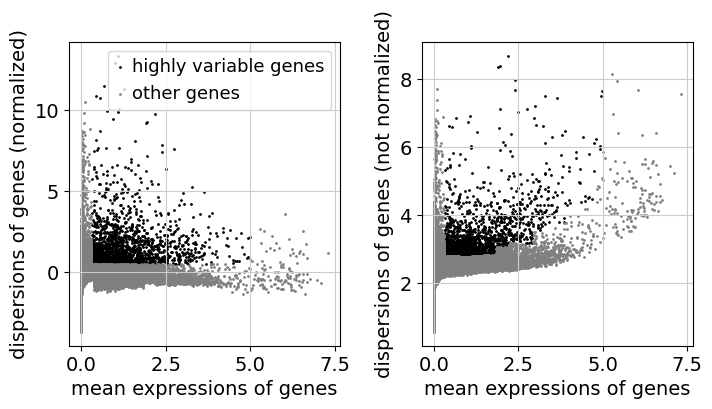

In [12]:
sc.pl.highly_variable_genes(progenitor)

normalizing counts per cell
    finished (0:00:00)


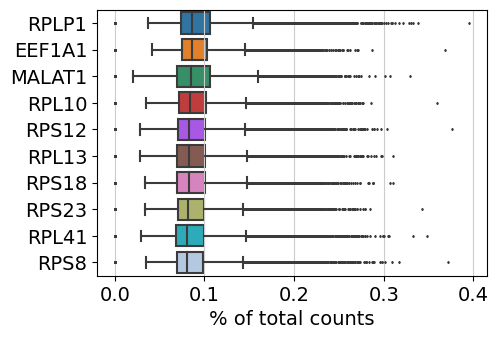

In [13]:
sc.pl.highest_expr_genes(progenitor, n_top=10, show=True)

### Perform comparison between t-test and wilcox data

ranking genes
    consider 'anno_lvl_2_final_clean' groups:
    with sizes: [3403 1395 3019 1670 9810 1936 1408 4740 1972 3862 2324  834]
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


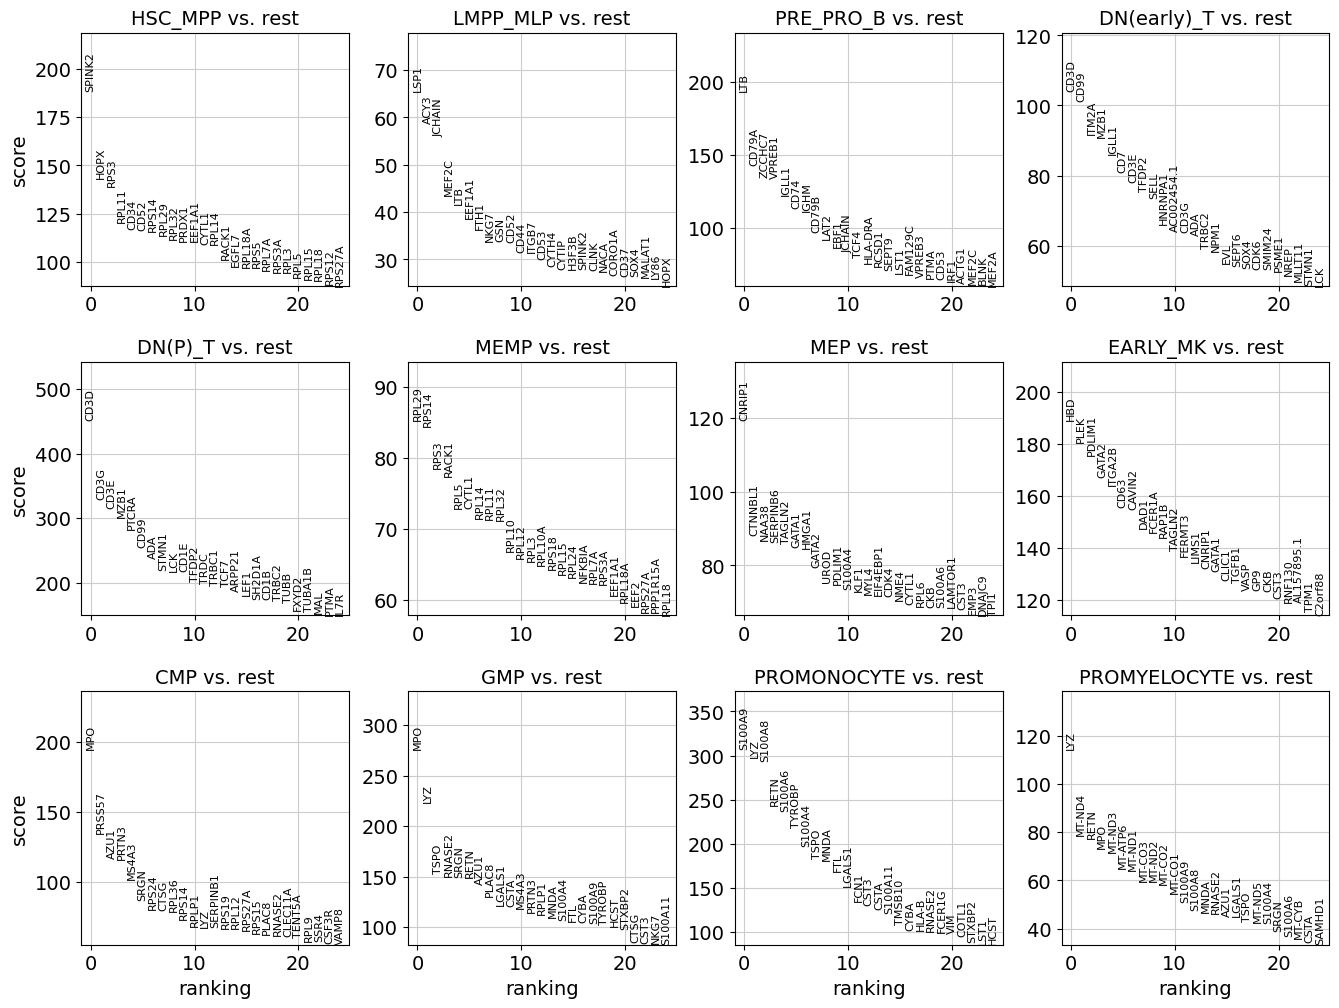

In [14]:
sc.tl.rank_genes_groups(progenitor, groupby= 'anno_lvl_2_final_clean', method='t-test', key_added= "t-test")
sc.pl.rank_genes_groups(progenitor,  n_genes=25,  sharey=False, key= "t-test")

ranking genes
    consider 'anno_lvl_2_final_clean' groups:
    with sizes: [3403 1395 3019 1670 9810 1936 1408 4740 1972 3862 2324  834]
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:04)


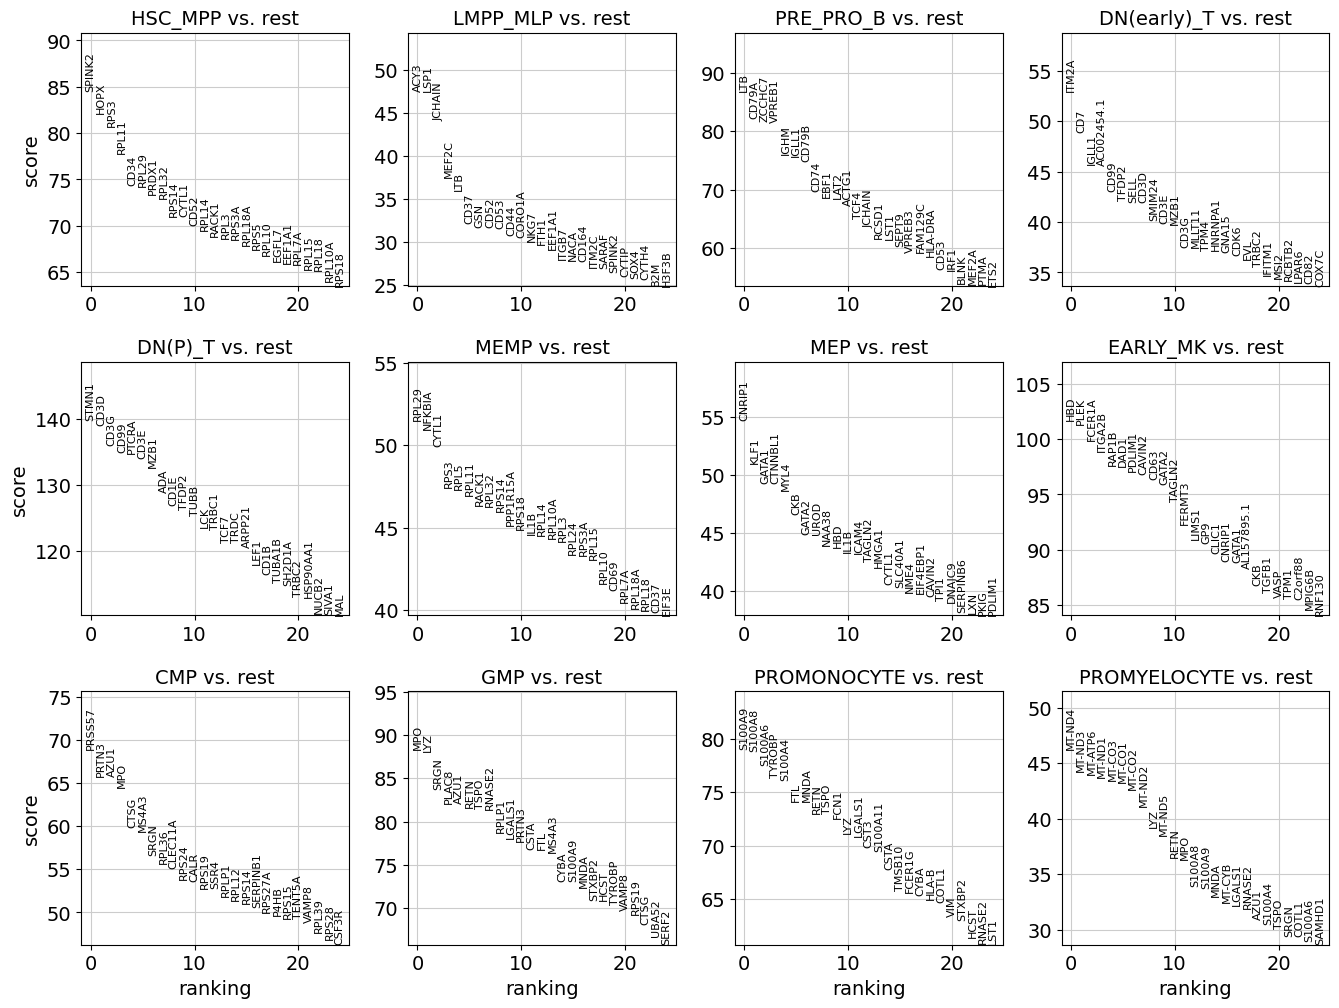

In [15]:
sc.tl.rank_genes_groups(progenitor, groupby= 'anno_lvl_2_final_clean', method='wilcoxon', key_added= "wilcoxon")
sc.pl.rank_genes_groups(progenitor,  n_genes=25,  sharey=False, key= "wilcoxon")

In [16]:
progenitor.write(tmpfile)

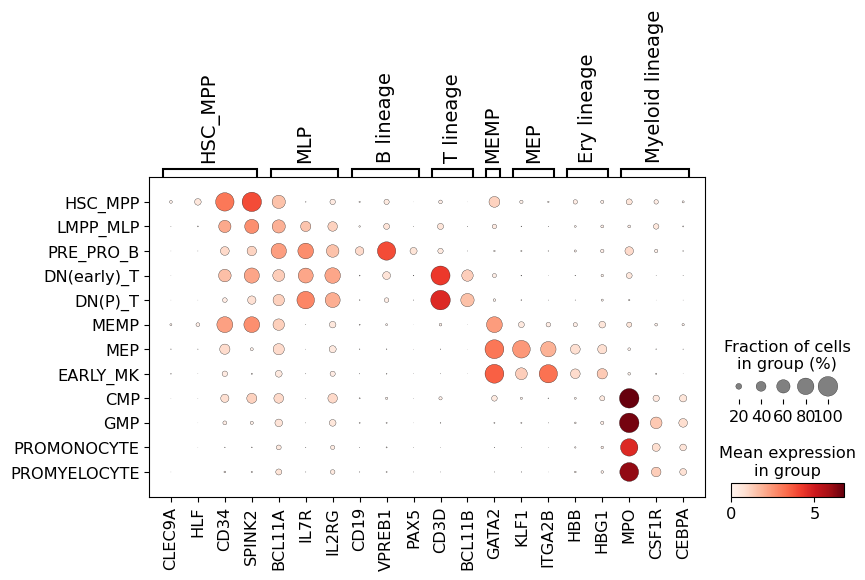

In [17]:
markers = {'HSC_MPP':['CLEC9A','HLF','CD34','SPINK2'],
           'MLP':['BCL11A','IL7R','IL2RG'],
           'B lineage':['CD19','VPREB1','PAX5'],
           'T lineage':['CD3D','BCL11B'],
           'MEMP':['GATA2'],
           'MEP':['KLF1','ITGA2B'],
           'Ery lineage':['HBB','HBG1'],
           'Myeloid lineage':['MPO','CSF1R','CEBPA']
          }
sc.pl.dotplot(progenitor, markers, 'anno_lvl_2_final_clean', dendrogram=False, use_raw=False, save='progenitor_anno.pdf')

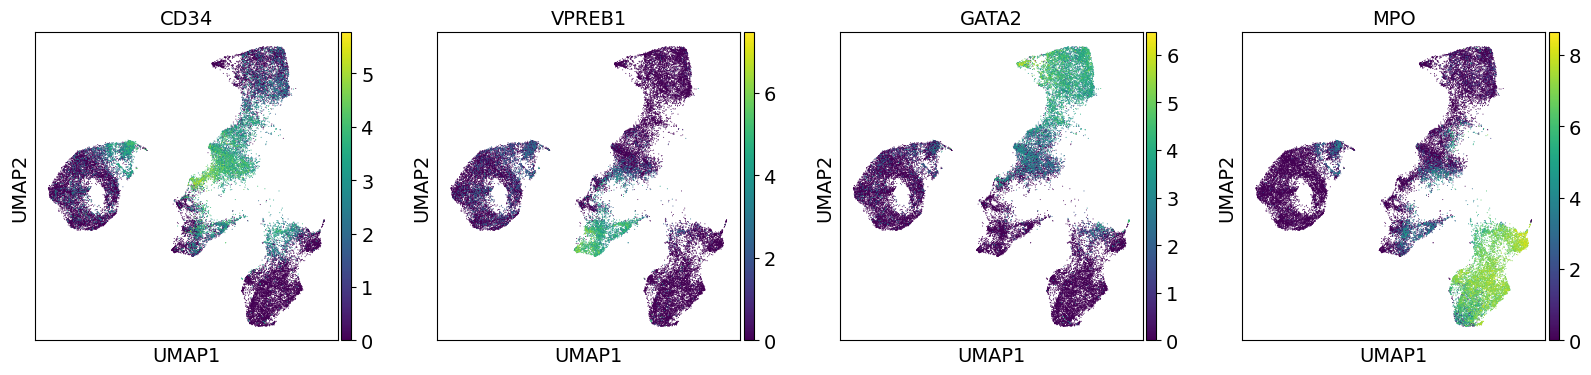

In [18]:
sc.pl.umap(progenitor, color= ["CD34", "VPREB1","GATA2" ,"MPO"], size=2 ) # top

## Read preprocessed data

In [4]:
adata = sc.read_h5ad(tmpfile)

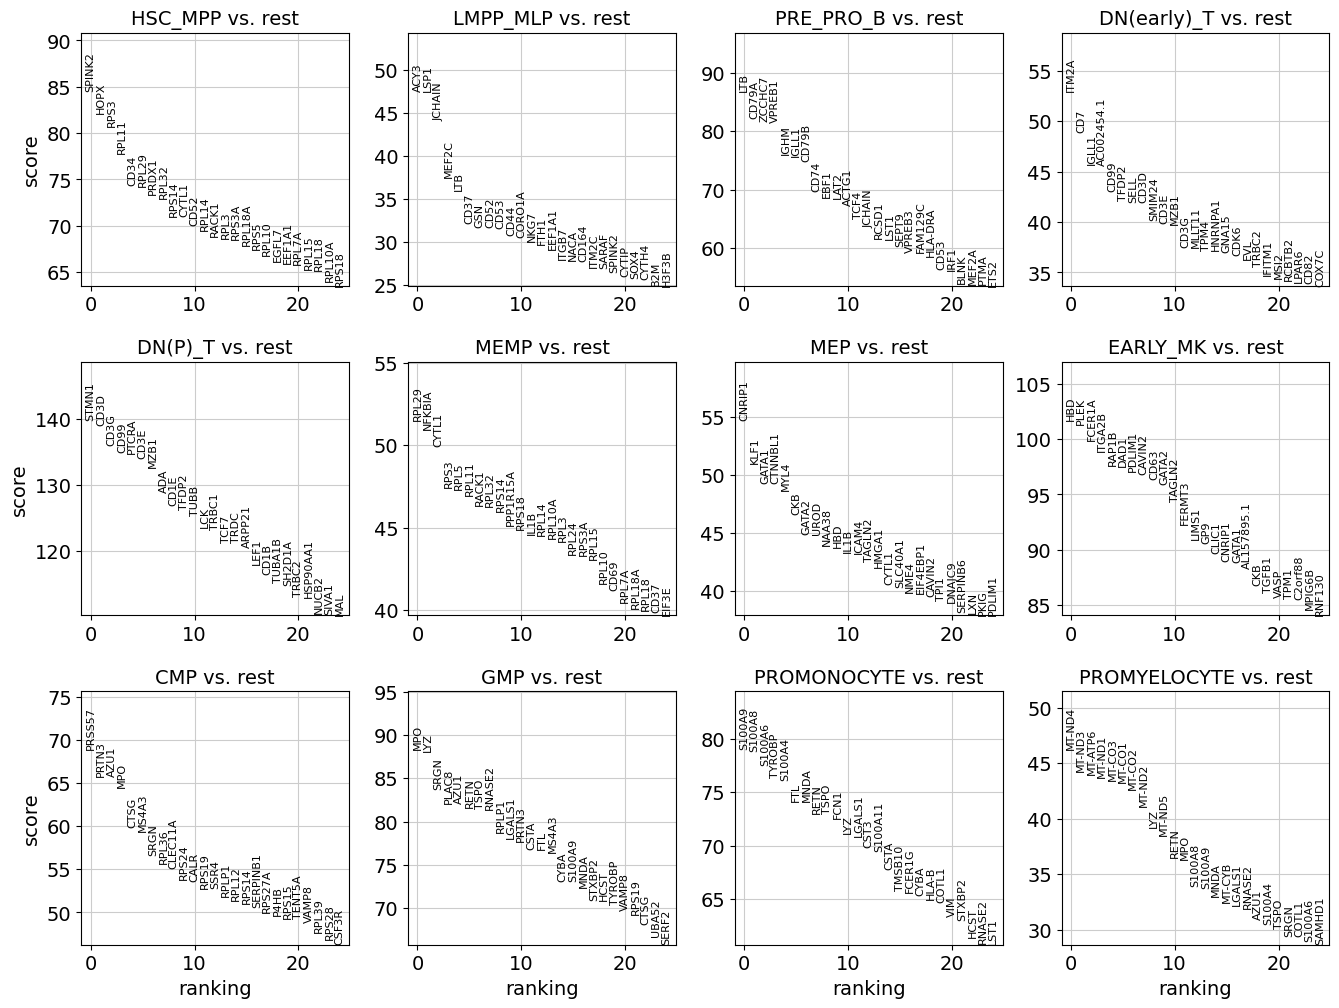

In [5]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "wilcoxon")

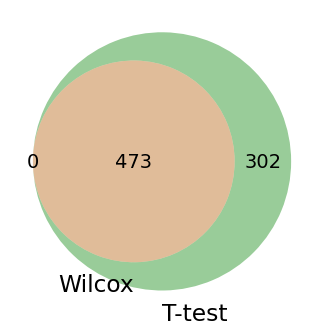

In [6]:
#compare CMP genes
from matplotlib_venn import venn2

wc = sc.get.rank_genes_groups_df(adata, group='DN(early)_T', key='wilcoxon', pval_cutoff=0.0001, log2fc_min=1)
tt = sc.get.rank_genes_groups_df(adata, group='DN(early)_T', key='t-test', pval_cutoff=0.0001, log2fc_min=1)

venn2([set(wc['names']),set(tt['names'])], ('Wilcox','T-test') )
plt.show()

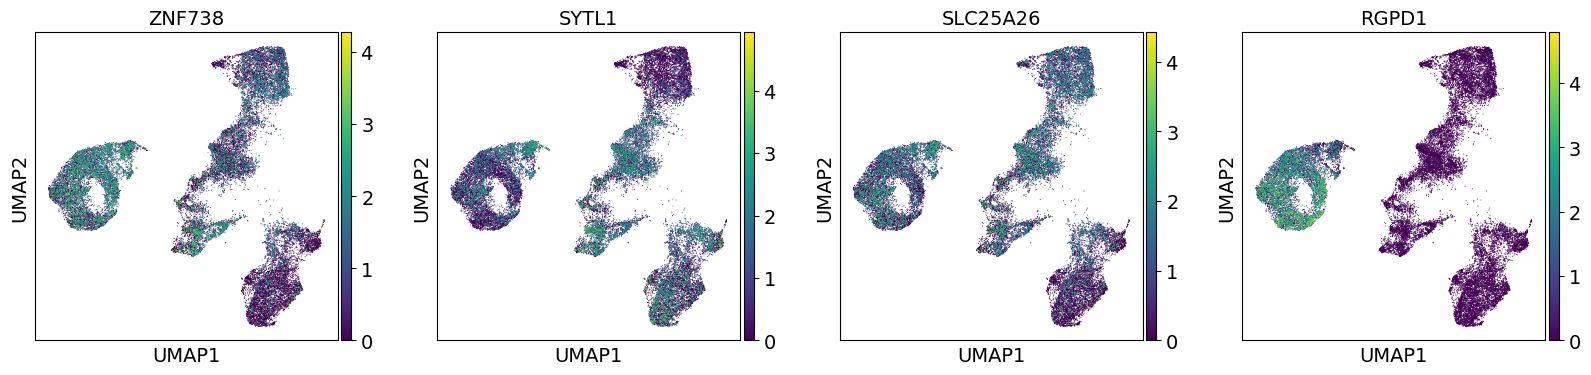

In [7]:
sc.pl.umap(adata, color= wc["names"][240:244], size=2 ) # top

## Loop to produce the lists of Progenitors subtypes

In [8]:
Subtypes = adata.obs['anno_lvl_2_final_clean'].unique()
Subtypes

['PRE_PRO_B', 'LMPP_MLP', 'MEMP', 'HSC_MPP', 'GMP', ..., 'PROMONOCYTE', 'CMP', 'DN(early)_T', 'MEP', 'DN(P)_T']
Length: 12
Categories (12, object): ['HSC_MPP', 'LMPP_MLP', 'PRE_PRO_B', 'DN(early)_T', ..., 'CMP', 'GMP', 'PROMONOCYTE', 'PROMYELOCYTE']

In [9]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])

0 PRE_PRO_B
1 LMPP_MLP
2 MEMP
3 HSC_MPP
4 GMP
5 EARLY_MK
6 PROMYELOCYTE
7 PROMONOCYTE
8 CMP
9 DN(early)_T
10 MEP
11 DN(P)_T


### Marker genes for each Subtype

In [10]:
Markers = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    m = sc.get.rank_genes_groups_df(adata, group=Subtypes[i],
                                    key='wilcoxon', pval_cutoff=0.0001,
                                    log2fc_min=1)
    m = m.sort_values("logfoldchanges", ascending=False)
    m.reset_index(drop=True, inplace=True)
    Markers[i] = m

0 PRE_PRO_B
1 LMPP_MLP
2 MEMP
3 HSC_MPP
4 GMP
5 EARLY_MK
6 PROMYELOCYTE
7 PROMONOCYTE
8 CMP
9 DN(early)_T
10 MEP
11 DN(P)_T


### Show UMAPS

In [10]:
#for i in range(0,len(Subtypes)):
#    ## Top markers
#    print(i, Subtypes[i])
#    sc.pl.umap(adata, color= Markers[i].loc[0:1,'names']) # top

### Get names of 300 top markers (if possible) for each Subtype

In [11]:
#pip install upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

In [12]:
Sets = [[]]*len(Subtypes)
CompleteSets = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    CompleteSets[i] = Markers[i]['names']
    n = len(Markers[i])
    #print(i, Subtypes[i], n)
    if n > 300 :
        #print("yes")
        Sets[i] = Markers[i].loc[0:299,'names']
    else :
        #print("no")
        Sets[i] = Markers[i].loc[0:n-1,'names']

In [13]:
Dict_markers =  {}
CompleteDict_markers =  {}

for i in range(0,len(Subtypes)):
    Dict_markers[Subtypes[i]] = Sets[i]
    CompleteDict_markers[Subtypes[i]] = CompleteSets[i]

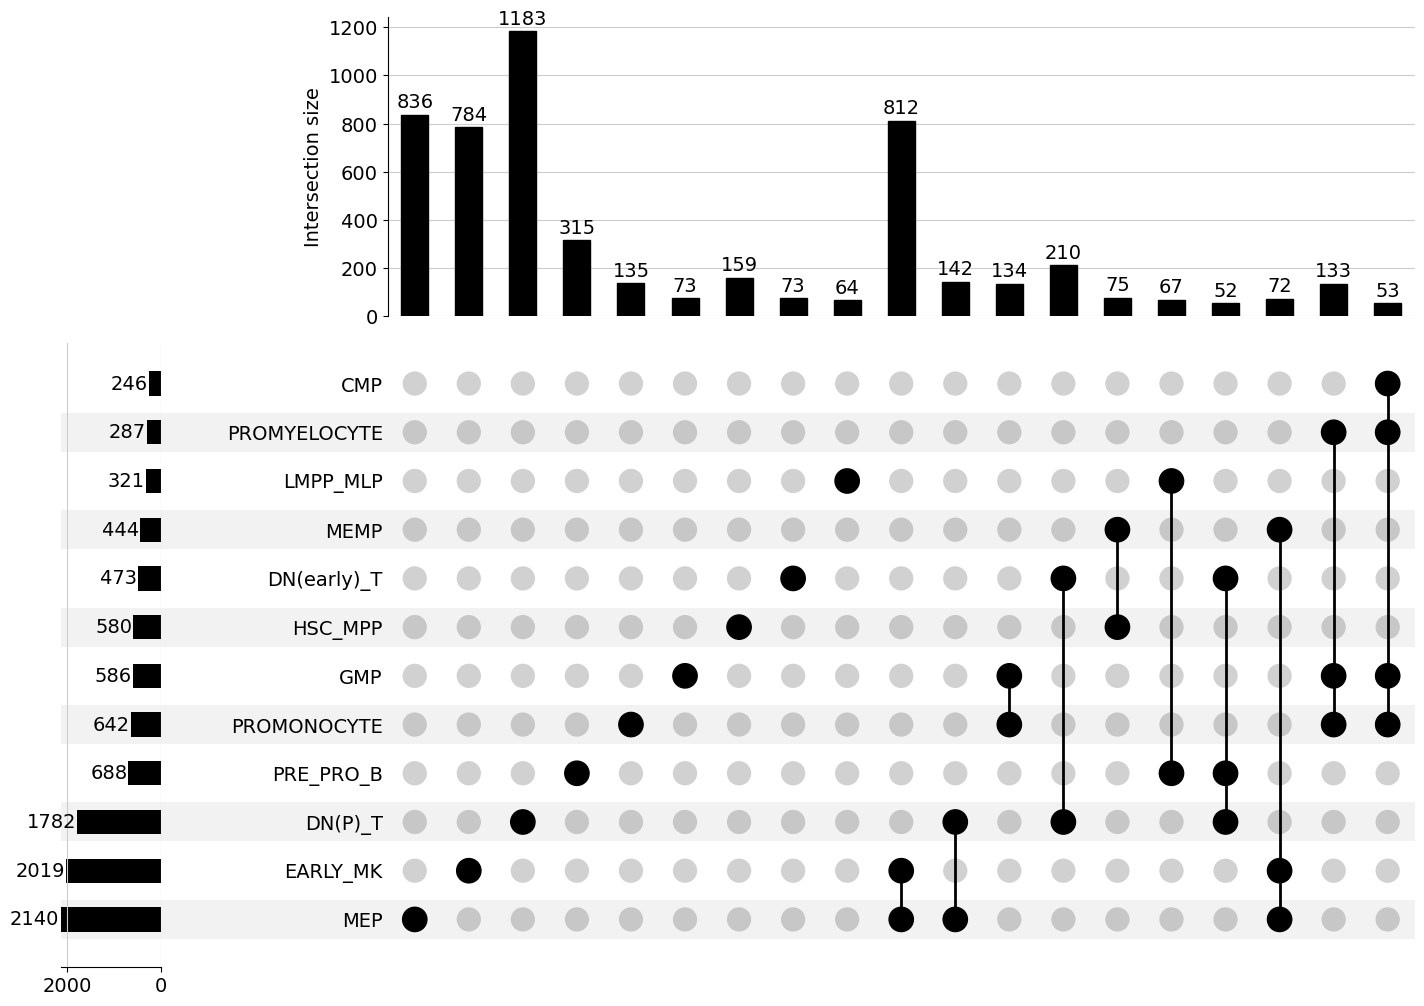

In [14]:
CT_markers = from_contents(CompleteDict_markers)

plt = UpSet(CT_markers, min_subset_size=50, subset_size='count',element_size=50,  show_counts=True).plot()

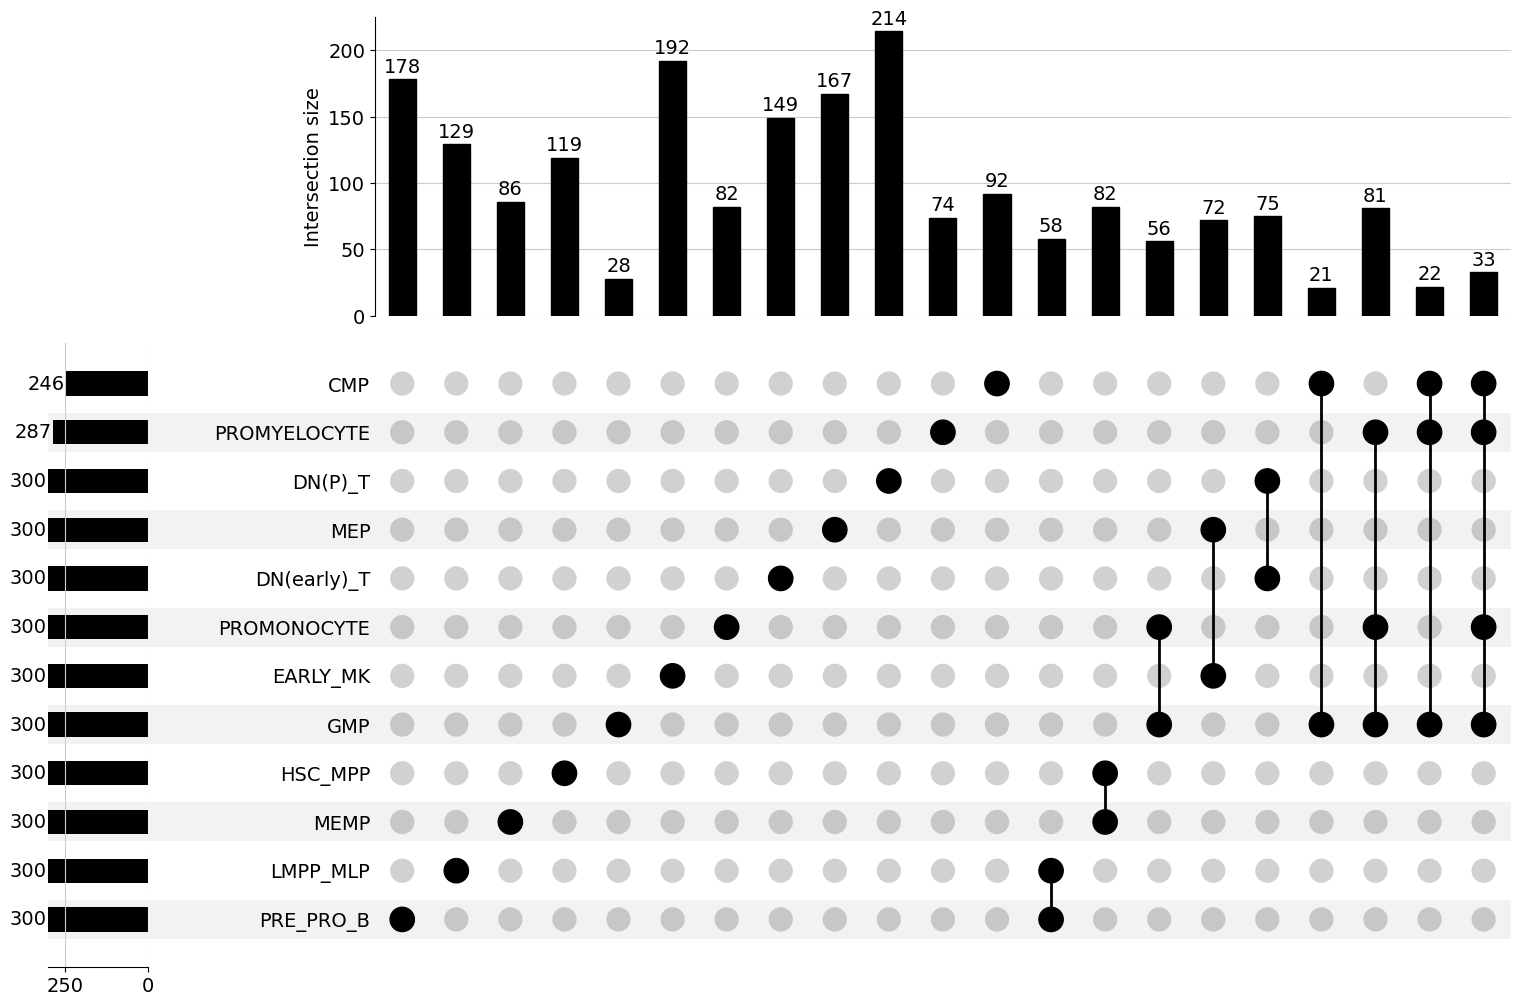

In [15]:
CT_markers = from_contents(Dict_markers)

plt = UpSet(CT_markers, min_subset_size=20, subset_size='count',element_size=50,  show_counts=True).plot()

In [16]:
Dict_markers['EARLY_MK'].loc[0:3]

0    LINC02197
1          HBD
2       FCER1A
3       LY6G6F
Name: names, dtype: object

In [17]:
#CT_markers.loc[(False,False,False,False,False,False,False,False,False,False,True), "id"]


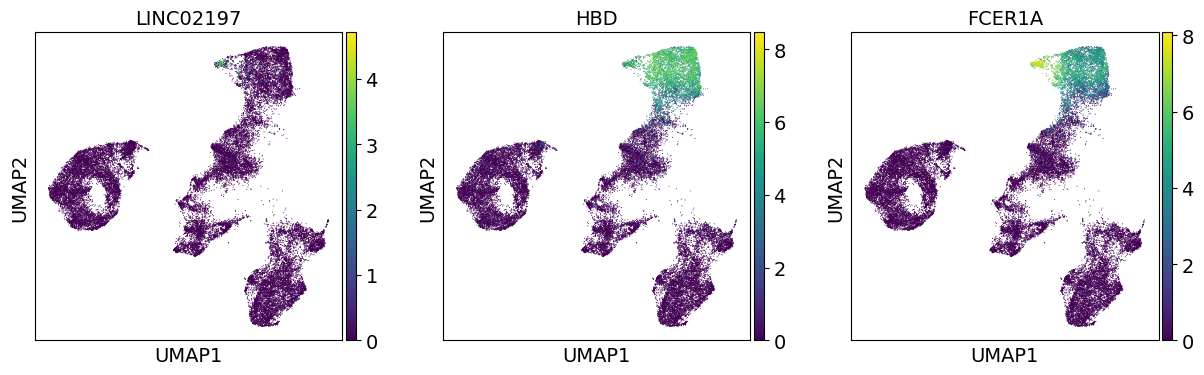

In [18]:
sc.pl.umap(adata, color= ["LINC02197", "HBD","FCER1A"], size= 2  ) # top

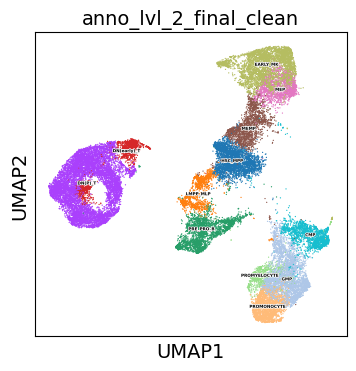

In [19]:
sc.pl.umap(adata, color=["anno_lvl_2_final_clean"],
           legend_loc = 'on data',legend_fontoutline =1,
           save= "HSC_progenitors.png", legend_fontsize= 3 )

In [20]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(Sets[0],  Sets[1], Sets[2],
                           Sets[3], Sets[4],  Sets[5],# Sets[6],
                           Sets[7], # Sets[8],
                           Sets[9],Sets[10], Sets[11])),
               columns =[Subtypes[0], Subtypes[1], Subtypes[2],
                         Subtypes[3], Subtypes[4], Subtypes[5],# Subtypes[6],
                         Subtypes[7],# Subtypes[8],
                         Subtypes[9], Subtypes[10], Subtypes[11]])

PROMYELOCYTE_df = pd.DataFrame(list(zip(Sets[6])),columns =[Subtypes[6]])

CMP_df = pd.DataFrame(list(zip(Sets[8])),columns =[Subtypes[8]])


df

,PRE_PRO_B,LMPP_MLP,MEMP,HSC_MPP,GMP,EARLY_MK,PROMONOCYTE,DN(early)_T,MEP,DN(P)_T
0,TNFRSF13B,ACY3,CXCL8,HOPX,LYZ,LINC02197,S100A8,CD3D,CNRIP1,CD1E
1,VPREB3,PRL,NFKBIA,SPINK2,MPO,HBD,S100A9,IGLL1,HBD,PTCRA
2,EBF1,CXCR3,IL1B,HLF,PRTN3,FCER1A,LYZ,DAND5,KLF1,CD1B
3,LCN6,XCL1,CYTL1,AVP,AZU1,LY6G6F,FCN1,SNORC,DHRS9,CD3D
4,VPREB1,GPR34,IL5RA,EMCN,RETN,CLEC1B,RETN,ETV5,GYPB,MAL
...,...,...,...,...,...,...,...,...,...,...
295,CCDC107,PTGER4,HOXB4,ADAMTS10,CEBPB,ZFPM2,WDFY3,GABARAPL1,NPW,CENPF
296,GPSM1,SMAGP,KRT18,IL16,TGFBI,SERPINB6,AP5B1,ZNRF1,FAM92A,MKI67
297,MS4A7,JAK3,CCDC125,AADAT,PLB1,DAD1,PLAUR,FDFT1,CMTM5,MTA3
298,NUDT7,USF2,EBPL,ZNF793,TESC,MAFG,CEBPE,AKAP2,MFNG,IGHV4-31


In [21]:
# pip install rpy2
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

In [22]:
%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
library("EnsDb.Hsapiens.v86")

head(df)

R[write to console]: Loading required package: ensembldb

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to cons

  PRE_PRO_B LMPP_MLP   MEMP HSC_MPP    GMP  EARLY_MK PROMONOCYTE DN(early)_T
0 TNFRSF13B     ACY3  CXCL8    HOPX    LYZ LINC02197      S100A8        CD3D
1    VPREB3      PRL NFKBIA  SPINK2    MPO       HBD      S100A9       IGLL1
2      EBF1    CXCR3   IL1B     HLF  PRTN3    FCER1A         LYZ       DAND5
3      LCN6     XCL1  CYTL1     AVP   AZU1    LY6G6F        FCN1       SNORC
4    VPREB1    GPR34  IL5RA    EMCN   RETN    CLEC1B        RETN        ETV5
5      IGHM IFNG-AS1   CD69   RAMP2 S100A9    ITGA2B     S100A12        MZB1
     MEP DN(P)_T
0 CNRIP1    CD1E
1    HBD   PTCRA
2   KLF1    CD1B
3  DHRS9    CD3D
4   GYPB     MAL
5  GATA1  ANKRD1


In [23]:
%%R

library(stringr)
dim(df)
genelists <- colnames(df)
path <- "~/Desktop/Github/Immune_Adaptation_Atlas/ENS_genelists_wilcox/HSC_progenitors/"

for (i in genelists)
    {
    goi <- df[,i]
    #print(i)
    f <- str_remove_all(i, "[()]")
    print(f)
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    #print(head(ens_df)) 

    write(x = ens_df, file = paste0(path, f ,"_ENSEMBL.txt"),ncolumns = 1)

    }


[1] "PRE_PRO_B"
[1] "LMPP_MLP"
[1] "MEMP"
[1] "HSC_MPP"
[1] "GMP"
[1] "EARLY_MK"
[1] "PROMONOCYTE"
[1] "DNearly_T"
[1] "MEP"
[1] "DNP_T"


In [24]:
%%R -i CMP_df
# import df from global environment
head(CMP_df)

goi <- CMP_df[,1]
f <- str_remove_all(colnames(CMP_df)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "CMP"
[1] "ENSG00000196415" "ENSG00000277804" "ENSG00000172232" "ENSG00000278624"
[5] "ENSG00000005381" "ENSG00000197561"


In [25]:
%%R -i PROMYELOCYTE_df
# import df from global environment
head(PROMYELOCYTE_df)

goi <- PROMYELOCYTE_df[,1]
f <- str_remove_all(colnames(PROMYELOCYTE_df)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "PROMYELOCYTE"
[1] "ENSG00000090382" "ENSG00000005381" "ENSG00000104918" "ENSG00000143546"
[5] "ENSG00000163220" "ENSG00000172232"


## Export full list of marker genes

In [26]:
full_csv_path = '~/Desktop/Github/Immune_Adaptation_Atlas/ENS_FULL_genelists_wilcox/HSC_progenitors/full.csv'

(pd.DataFrame.from_dict(data=CompleteDict_markers, orient='index')
   .to_csv(full_csv_path, header=False))

In [27]:
%%R -i full_csv_path
library("EnsDb.Hsapiens.v86")
library(stringr)

path <- "~/Desktop/Github/Immune_Adaptation_Atlas/ENS_FULL_genelists_wilcox/HSC_progenitors/"

mycsv <- read.csv(full_csv_path, row.names = 1,header = F, na.strings = "")

for (i in 1:nrow(mycsv))
{
    genelist <- row.names(mycsv)[i]
    n <- sum(!is.na(mycsv[i,]))
    #print(paste0(n," genes"))
    
    goi <- as.character(mycsv[i,1:n])
    print(goi[1:5])

    f <- str_remove_all(genelist, "[()]")
    print(f)
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    #print(head(ens_df)) 

    write(x = ens_df, file = paste0(path, f ,"_FULL_ENSEMBL.txt"),ncolumns = 1)

}


[1] "TNFRSF13B" "VPREB3"    "EBF1"      "LCN6"      "VPREB1"   
[1] "PRE_PRO_B"
[1] "ACY3"  "PRL"   "CXCR3" "XCL1"  "GPR34"
[1] "LMPP_MLP"
[1] "CXCL8"  "NFKBIA" "IL1B"   "CYTL1"  "IL5RA" 
[1] "MEMP"
[1] "HOPX"   "SPINK2" "HLF"    "AVP"    "EMCN"  
[1] "HSC_MPP"
[1] "LYZ"   "MPO"   "PRTN3" "AZU1"  "RETN" 
[1] "GMP"
[1] "LINC02197" "HBD"       "FCER1A"    "LY6G6F"    "CLEC1B"   
[1] "EARLY_MK"
[1] "LYZ"    "MPO"    "RETN"   "S100A8" "S100A9"
[1] "PROMYELOCYTE"
[1] "S100A8" "S100A9" "LYZ"    "FCN1"   "RETN"  
[1] "PROMONOCYTE"
[1] "PRTN3" "AZU1"  "MPO"   "ELANE" "CTSG" 
[1] "CMP"
[1] "CD3D"  "IGLL1" "DAND5" "SNORC" "ETV5" 
[1] "DNearly_T"
[1] "CNRIP1" "HBD"    "KLF1"   "DHRS9"  "GYPB"  
[1] "MEP"
[1] "CD1E"  "PTCRA" "CD1B"  "CD3D"  "MAL"  
[1] "DNP_T"
